<h1>Feature Engineering and Predictions</h1>

<h3>Focus on feature selection, processing speed, model iteration</h3>
<ul>
    <li>Will create different training sets w/ reature mixes</li>
    <li>PyTorch, Numba, Parralization, and Dask for processing speed</li>
    <li>Processing tutorial: <a href = 'https://towardsdatascience.com/speed-up-your-algorithms-part-3-parallelization-4d95c0888748'>speeding up your algorithms</a></li>
    <li>Split train into 3 train/test splits, run models and compare results before running on final test</li>
</ul>

In [1]:
from importlib import reload #for changes in helpers

import pandas as pd
import numpy as np
import scipy.stats

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import helpers
reload(helpers)

sns.set()

In [2]:
train = pd.read_csv('../geotab-data/train.csv')
test = pd.read_csv('../geotab-data/test.csv')

<h1>Target PCA</h1>

<ul>
    <li>Light summary eda</li>
    <li>Min max scaler and target PCA</li>
    <li>Not sure if this is necessary for purpose of this notebook</li>
    </ul>

In [3]:
targets = train.iloc[:,12:27]

#targets to predict
total_time = targets[['TotalTimeStopped_p20','TotalTimeStopped_p50', 'TotalTimeStopped_p80']]
distance_to_first = targets[['DistanceToFirstStop_p20','DistanceToFirstStop_p50','DistanceToFirstStop_p80']]
target_cols = list(total_time.columns) + list(distance_to_first.columns)
p_targets = targets[target_cols]

#optional targets
time_from_first = targets[['TimeFromFirstStop_p20','TimeFromFirstStop_p50','TimeFromFirstStop_p80']]

print('Target Summaries:')
display(helpers.summarize(p_targets, True))

Target Summaries:


,name,dtypes,missing,unique,first_val,last_val,max,mean,median,stdev,entropy
0,TotalTimeStopped_p20,int64,0,172,0.0,0.0,273.0,1.731272,0.0,7.080017,0.92
1,TotalTimeStopped_p50,int64,0,264,0.0,0.0,343.0,7.681874,0.0,15.553418,2.70
2,TotalTimeStopped_p80,int64,0,403,0.0,0.0,689.0,22.948071,16.0,28.118134,5.06
3,DistanceToFirstStop_p20,float64,0,3479,0.0,0.0,1902.7,6.564450,0.0,28.003261,1.35
4,DistanceToFirstStop_p50,float64,0,7483,0.0,0.0,3099.5,28.255852,0.0,71.720090,4.16
5,DistanceToFirstStop_p80,float64,0,13267,0.0,0.0,4064.3,81.922639,60.4,152.682760,8.10


In [4]:
#scale targets w/ a min max scalers and append to train
for col in target_cols:
    train[col+str("_minmax")] = (preprocessing.minmax_scale(train[col], feature_range=(0,1)))
    
min_max_cols = ['TotalTimeStopped_p20_minmax', 'TotalTimeStopped_p50_minmax',
                'TotalTimeStopped_p80_minmax', 'DistanceToFirstStop_p20_minmax',
                'DistanceToFirstStop_p50_minmax', 'DistanceToFirstStop_p80_minmax']

pca = PCA(n_components=3, random_state=5)

principalComponents = pca.fit_transform(train[min_max_cols])
principalDf = pd.DataFrame(principalComponents)
pca.explained_variance_ratio_

array([0.66396904, 0.17536384, 0.07856878])

<h1>Feature Engineering</h1>

Time and day features

In [5]:
#making hour columns cyclical
train = helpers.date_cyc_enc(train, 'Hour', 24)
test = helpers.date_cyc_enc(test, 'Hour', 24) 

#encoding time of day
train['is_day'] = train['Hour'].apply(lambda x: 1 if 7 < x < 18 else 0)
test['is_day'] = test['Hour'].apply(lambda x: 1 if 7 < x < 18 else 0)

train['is_morning'] = train['Hour'].apply(lambda x: 1 if 6 < x < 10 else 0)
test['is_morning'] = test['Hour'].apply(lambda x: 1 if 6 < x < 10 else 0)

train['is_night'] = train['Hour'].apply(lambda x: 1 if 17 < x < 20 else 0)
test['is_night'] = test['Hour'].apply(lambda x: 1 if 17 < x < 20 else 0)

#encoding weekend vs not weekend
train['is_day_weekend'] = np.where((train['is_day'] == 1) & (train['Weekend'] == 1), 1,0)
test['is_day_weekend'] = np.where((test['is_day'] == 1) & (train['Weekend'] == 1), 1,0)

train['is_mor_weekend'] = np.where((train['is_morning'] == 1) & (train['Weekend'] == 1), 1,0)
test['is_mor_weekend'] = np.where((test['is_morning'] == 1) & (train['Weekend'] == 1), 1,0)

train['is_nig_weekend'] = np.where((train['is_night'] == 1) & (train['Weekend'] == 1), 1,0)
test['is_nig_weekend'] = np.where((test['is_night'] == 1) & (train['Weekend'] == 1), 1,0)

Location and direction features

In [6]:
#intersection and city concat
train["Intersec"] = train["IntersectionId"].astype(str) + train["City"]
test["Intersec"] = test["IntersectionId"].astype(str) + test["City"]

#make numerical and drop concat
le = LabelEncoder()
le.fit(pd.concat([train["Intersec"],test["Intersec"]]).drop_duplicates().values)
train["Intersec"] = le.transform(train["Intersec"])
test["Intersec"] = le.transform(test["Intersec"])

train['EntryType'] = train['EntryStreetName'].apply(helpers.road_encode)
train['ExitType'] = train['ExitStreetName'].apply(helpers.road_encode)
test['EntryType'] = test['EntryStreetName'].apply(helpers.road_encode)
test['ExitType'] = test['ExitStreetName'].apply(helpers.road_encode)

#map directional encoding in in train and test
train['EntryHeading'] = train['EntryHeading'].map(helpers.directions)
train['ExitHeading'] = train['ExitHeading'].map(helpers.directions)
test['EntryHeading'] = test['EntryHeading'].map(helpers.directions)
test['ExitHeading'] = test['ExitHeading'].map(helpers.directions)

#heading differences will tell us the degree at which you traveled, (0 degrees is straight, 180 u turn)
train['diffHeading'] = train['EntryHeading']-train['ExitHeading']  
test['diffHeading'] = test['EntryHeading']-test['ExitHeading'] 

#if you stay on the same street feature
train["same_str"] = (train["EntryStreetName"] ==  train["ExitStreetName"]).astype(int)
test["same_str"] = (test["EntryStreetName"] ==  test["ExitStreetName"]).astype(int)

Secondary features, monthly rainfall by city 

In [7]:
# Concatenating the city and month into one variable
train['city_month'] = train["City"] + train["Month"].astype(str)
test['city_month'] = test["City"] + test["Month"].astype(str)

# Creating a new column by mapping the city_month variable to it's corresponding average monthly rainfall
train["average_rainfall"] = train['city_month'].map(helpers.monthly_rainfall)
test["average_rainfall"] = test['city_month'].map(helpers.monthly_rainfall)

Replace city w/ dummy variables, can't run cells above after this

In [8]:
#dummy variables for city, drops city
try:
    train = pd.get_dummies(train, columns=['City' ],prefix=['City'], drop_first=False)
    test = pd.get_dummies(test, columns=['City' ],prefix=['City'], drop_first=False)
except KeyError:
    pass

Scale lat and longitude

In [9]:
#wonder if this would be different with min max
scaler = preprocessing.StandardScaler()
for col in ['Latitude','Longitude']:
    scaler.fit(train[col].values.reshape(-1, 1))
    train[col] = scaler.transform(train[col].values.reshape(-1, 1))
    test[col] = scaler.transform(test[col].values.reshape(-1, 1))

In [10]:
train.drop(['RowId', 'Path','EntryStreetName','ExitStreetName'],axis=1, inplace=True)
test.drop(['RowId', 'Path','EntryStreetName','ExitStreetName'],axis=1, inplace=True)

In [11]:
final_features = ['IntersectionId', 'Latitude', 'Longitude', 'EntryHeading',
                    'ExitHeading', 'Hour', 'Weekend', 'Month',
                    'is_morning', 'is_night', 'is_day_weekend', 'is_mor_weekend',
                    'is_nig_weekend', 
                    #'Hour', 
                    'Hour_sin', 
                    'Hour_cos', 
                    'same_str', 'Intersec', 'EntryType',
                    'ExitType', 'diffHeading', 'average_rainfall', 'is_day',
                    'City_Boston', 'City_Chicago', 'City_Philadelphia', 
                    'City_Atlanta']

<h1>Model building</h1>
Useful Vaiables:
<ul>
    <li>final_features - list final set of features for prediction</li>
    <li>target_cols - list of targets to predict</li>
    <li>train - full train data set with derived features</li>
    <li>test - full test data set with derived features</li>
</ul>

In [12]:
print("Train dataset shape: "+ str(train.shape))
print("Test dataset shape:  "+ str(test.shape))

Train dataset shape: (857409, 48)
Test dataset shape:  (1920335, 27)


In [15]:
#X and y for train set
X = train[final_features]
y = train[target_cols]

#only run this at the end, to get final prediction
X_final = test[final_features]

#reduce mem usage on feature sets (X)
X = helpers.reduce_mem_usage(X)
X_final = helpers.reduce_mem_usage(X_final)

/Users/devonnavon/Code/kaggle/geotab-intersection/helpers.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(np.int16)
/Users/devonnavon/Code/kaggle/geotab-intersection/helpers.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(np.float64)
/Users/devonnavon/Code/kaggle/geotab-intersection/helpers.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

Mem. usage decreased to 68.69 Mb (53.3% reduction)
Mem. usage decreased to 153.84 Mb (53.3% reduction)


<h3>Model iteration and validation</h3>
<ul>
    <li>Below we split original train into 2 train/tests using different random seeds</li>
    <li>We do so to test accuracy of model before crating final sumbission, which we can't pre score</li>
</ul>

In [16]:
#75% to train and 25% to test
validation_size = 0.25

X_train_1, X_validation_1, Y_train_1, Y_validation_1 = train_test_split(X, y, test_size=validation_size, random_state=7)
X_train_2, X_validation_2, Y_train_2, Y_validation_2 = train_test_split(X, y, test_size=validation_size, random_state=3)

In [17]:
#to test speed, we will run prediciton on a single y split from our original train data
# y1 = train['TotalTimeStopped_p20']
# y2 = train['TotalTimeStopped_p50']
y3 = train['TotalTimeStopped_p80']
# y4 = train['DistanceToFirstStop_p20']
# y5 = train['DistanceToFirstStop_p50']
# y6 = train['DistanceToFirstStop_p80']

X_train_speed, X_validation_speed, Y_train_speed, Y_validation_speed = train_test_split(X, y3, test_size=validation_size, random_state=12)

In [30]:
%%time
#model
lr = RandomForestRegressor(n_estimators=10,min_samples_split=3)

CPU times: user 24 µs, sys: 1e+03 ns, total: 25 µs
Wall time: 27.9 µs


In [31]:
%%time
lr.fit(X_train_speed, Y_train_speed)

CPU times: user 51.9 s, sys: 386 ms, total: 52.3 s
Wall time: 51.4 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [32]:
%%time
preds_1 = lr.predict(X_validation_speed)

CPU times: user 1.11 s, sys: 30.7 ms, total: 1.14 s
Wall time: 1.14 s


In [33]:
np.sqrt(mean_squared_error(preds_1, Y_validation_speed))

17.65346223128817

In [41]:
%%time
import dask_ml.joblib
from sklearn.externals import joblib
import distributed

client = Client()
with joblib.parallel_backend('dask'):
    lr.fit(X_train_speed, Y_train_speed)
    preds_1 = lr.predict(X_validation_speed)

ModuleNotFoundError: No module named 'distributed.joblib'

In [38]:
import distributed.joblib

ModuleNotFoundError: No module named 'distributed.joblib'

In [40]:
%%time
from dask_ml.wrappers import ParallelPostFit
el = ParallelPostFit(estimator=lr)
el.fit(X_train_speed, Y_train_speed)
preds = el.predict(X_validation_speed)

CPU times: user 54.1 s, sys: 532 ms, total: 54.6 s
Wall time: 53.8 s


In [47]:
importances = list(lr.feature_importances_)

In [56]:
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(final_features, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]
print('')

Variable: Latitude             Importance: 0.16
Variable: Longitude            Importance: 0.14
Variable: IntersectionId       Importance: 0.1
Variable: Intersec             Importance: 0.1
Variable: EntryHeading         Importance: 0.05
Variable: ExitHeading          Importance: 0.05
Variable: Month                Importance: 0.05
Variable: Hour_cos             Importance: 0.05
Variable: same_str             Importance: 0.05
Variable: average_rainfall     Importance: 0.05
Variable: Hour_sin             Importance: 0.04
Variable: diffHeading          Importance: 0.04
Variable: Hour                 Importance: 0.03
Variable: Weekend              Importance: 0.02
Variable: EntryType            Importance: 0.02
Variable: ExitType             Importance: 0.02
Variable: City_Philadelphia    Importance: 0.01
Variable: is_morning           Importance: 0.0
Variable: is_night             Importance: 0.0
Variable: is_day_weekend       Importance: 0.0
Variable: is_mor_weekend       Importance: 0.

Text(0.5, 1.0, 'Variable Importances')

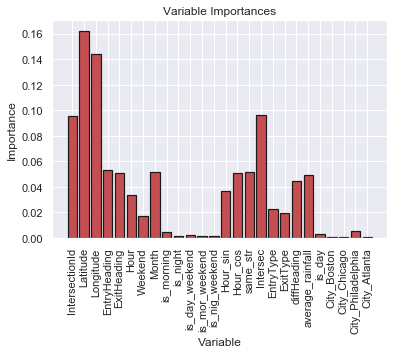

In [52]:
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, final_features, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')

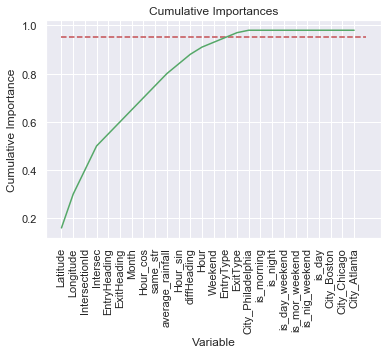

In [53]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');